In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [2]:
seen_df = pd.read_csv('data/0_labelled_documents.csv')
seen_df = seen_df[pd.notna(seen_df['INCLUDE'])]
seen_df["seen"] = 1
unseen_df = pd.read_csv('data/0_unlabelled_documents.csv')
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head()

(531125, 110)


,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,9 - 0. Ex-post,9 - 1. Ex-ante,9 - 2. Ex-ante (IAM),INCLUDE,representative_sample,seen,wosarticle__de,wosarticle__wc,relevant,random
0,3812405,South Asian summer monsoon projections constra...,A reliable projection of future South Asian su...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,['Multidisciplinary Sciences'],0.0,0.0
1,233883,Millennial to interannual climate variability ...,Climate change during the late Pleistocene is ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0
2,1857568,Modeling of CO2 Adsorption on Activated Carbon...,"Due to carbon dioxide role in global warming, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,"['Engineering, Chemical; Materials Science, Mu...",0.0,0.0
3,574396,The positive effects of bed material coating o...,The utilization of biomass for the substitutio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,Biomass gasification; Bed material; Catalytic ...,"['Energy & Fuels; Engineering, Chemical']",0.0,0.0
4,545538,Numerical simulation and optimization of CO2 s...,With heightened concerns on CO2 emissions from...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,CO2 sequestration; Computational fluid dynamic...,"['Computer Science, Interdisciplinary Applicat...",0.0,0.0


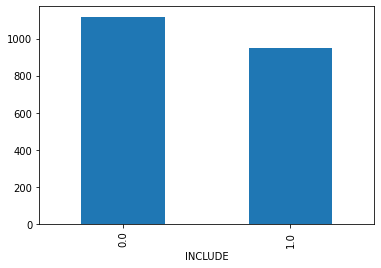

In [3]:
seen_df.groupby('INCLUDE').size().plot.bar()

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Here we define the whole pipeline starting from creating features to training a classifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(probability=True,  class_weight="balanced")),
])

# Now we define the parameter space we want to search. This gets computationally expensive the 
# more parameters we search, as we fit a model for every unique combination of parameters (there are fancier and smarter ways to do this)

parameters = [
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['rbf'], 
        'clf__gamma': [1e-3, 1e-4], # Because only the rbf kernel has the gamma parameters, we do this separately
        'clf__C': [1, 1e1, 1e2]
    },
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [1e2, 1e3]
    }
]

clf = GridSearchCV(pipeline, parameters, scoring="f1", n_jobs=4, verbose=1)

In [5]:
retrain = False
if retrain:
    # Now we fit them, by default we try a model for each set of parameters for 5 folds of train/test data
    # Even with this running in parallel (n_jobs=8) this might be time to get a coffee
    clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'INCLUDE'])
    # The best model is the combination of parameters with the highest mean score across 5 folds
    clf.best_estimator_

In [6]:
if retrain:
    # We can also put the results into a dataframe
    results = pd.DataFrame(clf.cv_results_)
    results.head()

In [7]:
if retrain:
    # Now if we want to look at what the individual parameters do we can plot the range of results obtained
    # with each value of the parameter
    def param_boxes(results, param, scorer="F1"):
        fig, ax = plt.subplots(figsize=(7,4))
        # A list of values for our boxplot
        x = []
        labels = []
        for i, (name, group) in enumerate(results.groupby(param)):
            labels.append(name)
            x.append(group['mean_test_score'])
        ax.boxplot(x)
        ax.set_xticklabels(labels)
        ax.set_xlabel(param)
        ax.set_ylabel(scorer)
        plt.show()

    param_boxes(results, "param_clf__C")

In [8]:
if retrain:
    # This also works for a combination of params
    param_boxes(results, ["param_clf__kernel","param_clf__C"])

In [9]:
if retrain:
    param_boxes(results, "param_vect__ngram_range")

In [10]:
if retrain:
    param_boxes(results, "param_vect__min_df")

In [11]:
if retrain:
    param_boxes(results, "param_vect__max_df")

In [12]:
if retrain:
    clf = clf
else:
    clf = Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, min_df=5)),
                ('clf',
                 SVC(C=100.0, class_weight='balanced', gamma=0.001,
                     probability=True))])

In [13]:
# We can fit our best model with the whole training set now 
clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'INCLUDE'])
# And obtain predictions for all that we have not yet seen
y_pred = clf.predict_proba(df.loc[unseen_index,'content'])

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


45708


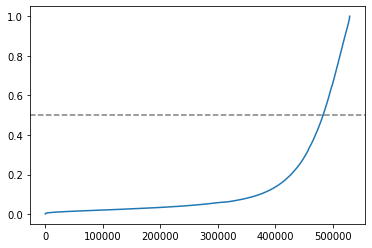

In [14]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [15]:
django.db.connection.close()
assigned = set(DocOwnership.objects.filter(query=8843).values_list('doc_id',flat=True))
len(assigned)

2240

In [16]:
django.db.connection.close()
pairs = [
    (['vasudevan@mcc-berlin.net','lucy.banisch@icloud.com'], 100),      
    (['doebbeling@mcc-berlin.net','galm'], 20),   
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 16",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id) - assigned

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [17]:
django.db.connection.close()
pairs = [
    (['vasudevan@mcc-berlin.net','lucy.banisch@icloud.com'], 80),      
    (['doebbeling@mcc-berlin.net','galm'], 20),   
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 15",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id) - assigned

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [29]:
django.db.connection.close()
pairs = [
    (['vasudevan@mcc-berlin.net','lucy.banisch@icloud.com'], 60),      
    (['ceposadap@gmail.com','edmondson@hertie-school.org'], 40),   
    (['vasudevan@mcc-berlin.net','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 12",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [20]:
import pandas as pd

django.db.connection.close()
pairs = []
for do in DocOwnership.objects.filter(tag=tag,user__username="vasudevan@mcc-berlin.net"):
    odo = DocOwnership.objects.filter(tag=tag, doc=do.doc).exclude(pk=do.id).first()
    pairs.append({"title":odo.doc.title,"user":odo.user})
df = pd.DataFrame.from_dict(pairs)
df.to_csv('document_pairs.csv',index=False)
df.head()

,title,user
0,Factors influencing German house owners' prefe...,lucy.banisch@icloud.com
1,Increased energy efficiency and the rebound ef...,lucy.banisch@icloud.com
2,Socially responsible or reprehensible? Investo...,lucy.banisch@icloud.com
3,Carbon Prices for the Next Hundred Years,lucy.banisch@icloud.com
4,Determinants of carbon accounting disclosure: ...,lucy.banisch@icloud.com


In [30]:
pairs = [
    (['vasudevan@mcc-berlin.net','galm'], 40),      
    (['ceposadap@gmail.com','edmondson@hertie-school.org'], 20),   
    (['lucy.banisch@icloud.com','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 10",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [31]:
pairs = [
    (['vasudevan@mcc-berlin.net','lucy.banisch@icloud.com'], 80),      
    (['doebbeling@mcc-berlin.net','edmondson@hertie-school.org'], 20),   
    (['galm','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 11",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [32]:
pairs = [
    (['vasudevan@mcc-berlin.net','doebbeling@mcc-berlin.net'], 80),      
    (['lucy.banisch@icloud.com','ceposadap@gmail.com'], 160),
    (['edmondson@hertie-school.org','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 13",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [11]:
django.db.connection.close()

pairs = [
    (['vasudevan@mcc-berlin.net','doebbeling@mcc-berlin.net'], 20),      
    (['lucy.banisch@icloud.com','vasudevan@mcc-berlin.net'], 60),
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 14",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [ ]:
import pandas as pd

django.db.connection.close()
pairs = []
for do in DocOwnership.objects.filter(tag=tag,user__username="vasudevan@mcc-berlin.net"):
    odo = DocOwnership.objects.filter(tag=tag, doc=do.doc).exclude(pk=do.id).first()
    pairs.append({"title":odo.doc.title,"user":odo.user})
df = pd.DataFrame.from_dict(pairs)
df.to_csv('document_pairs.csv',index=False)
df.head()

In [22]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=9046)
tag, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()


users = q.users.all()
uc = len(users)

new_docs = (df
            .sort_values('prediction',ascending=False)
            .head(50)
            .reset_index(drop=True)
           )

for i, row in new_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    u = users[i % uc]
    for u in users:
        do, created = DocOwnership.objects.get_or_create(
            doc=d,
            user=u,
            query=q,
            tag=tag
        )
        do.save()
    
tag.update_tag()

In [15]:
tag

<Tag: Probably relevant random sample 14>

In [21]:
django.db.connection.close()
tag = Tag.objects.get(title="Probably relevant random sample 13")
tag
dos = DocOwnership.objects.filter(tag=tag,relevant=0,user__username__icontains="edmondson")
u = User.objects.get(username="galm")
dos.update(user=u)
dos.count()

0